In [1]:
# to get started, we will import these libraries
import urllib.request, json 
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from sodapy import Socrata

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# next we will connect to the data portal to load in vacant parcel data from LA County Assessor
client = Socrata("data.lacounty.gov", None)

# The website says this dataset has 176K rows, we are going to try to call in all of them using 180K in case more have been added. However, we are also going to limit our data to Los Angeles incorporated
results = client.get("vcaw-zeg9", limit=180000, where="taxratearea_city=='LOS ANGELES'")

# We'll need to convert to pandas DataFrame
vacdf = pd.DataFrame.from_records(results)

vacdf.sample(5)

usecodedescchar1 roll_homeownersexemp situsunit recordingdate  \
1715       Residential                    0                20130129   
10387       Commercial                    0                20030415   
1954       Residential                    0                20080722   
14955       Industrial                    0                20130828   
27727      Residential                    0                20020304   

      effectiveyearbuilt istaxableparcel roll_totlandimp roll_perspropexemp  \
1715                   0               Y          107583                  0   
10387                  0               Y           56889                  0   
1954                   0               Y           17053                  0   
14955                  0               Y          370762                  0   
27727                  0               Y           28265                  0   

                               parcelboundarydescription roll_landbaseyear  \
1715                                     TR=72214 LOT 18              2013   
10387                     TRACT # 5809 EX OF ST LOT  162              1975   
1954   TRACT # 2955 S 11.5 FT OF E 150 FT OF W 180 FT...              2006   
14955                       FINLEY TRACT EX OF ST LOT 39              2014   
27727             PASADENA VILLA TRACT LOT    5 BLK   58              2002   

       ...                                         location_1 bathrooms  \
1715   ...  {'latitude': '34.20150185', 'needs_recoding': ...         0   
10387  ...  {'latitude': '33.99169877', 'needs_recoding': ...         0   
1954   ...  {'latitude': '34.15852672', 'needs_recoding': ...         0   
14955  ...  {'latitude': '34.05562311', 'needs_recoding': ...         0   
27727  ...  {'latitude': '34.09612045', 'needs_recoding': ...         0   

      sqftmain situsdirection roll_realestateexemp   center_lat    situszip  \
1715         0                                   0  34.20150185               
10387        0                                   0  33.99169877  90291-5042   
1954         0                                   0  34.15852672               
14955        0                                   0  34.05562311  90006-1734   
27727        0                                   0  34.09612045               

      yearbuilt                               propertylocation situszip5  
1715          0                                            NaN       NaN  
10387         0       2521 LINCOLN BLVD  LOS ANGELES CA  90291     90291  
1954          0                                            NaN       NaN  
14955         0  2854 JAMES M WOOD BLVD  LOS ANGELES CA  90006     90006  
27727         0                                            NaN       NaN  

[5 rows x 51 columns]

In [3]:
# we need to replace null objects with "n/a" in order to analyze and plot this important data on the designated use type of these parcels later
vacdf['usecodedescchar1'].fillna('N/A')

0         Industrial
1        Residential
2        Residential
3        Residential
4        Residential
            ...     
33086    Residential
33087    Residential
33088    Residential
33089     Commercial
33090    Residential
Name: usecodedescchar1, Length: 33091, dtype: object

In [4]:
# we will need to convert our df to gdf. Since data is in lat/lon's we will assign crs to WGS84 (epsg:4326)
vacgdf = gpd.GeoDataFrame(vacdf, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(vacdf.center_lon, vacdf.center_lat))

In [5]:
# importing our community boundaries dataset by referencing API from data source and using shapely to convert the geometries

import shapely
from shapely.geometry import shape

comdf = pd.read_json( r'https://data.lacounty.gov/resource/frhs-h972.json' )
comdf = comdf[comdf["lcity"].str.contains("Los Angeles") == True]
comdf['the_geom'] = comdf['the_geom'].apply(shape)
comgdf = gpd.GeoDataFrame(comdf).set_geometry('the_geom')

comgdf.sample(5)

objectid city_type        lcity                          label   source  \
333       100      City  Los Angeles  Los Angeles - Hollywood Hills  LA City   
115        75      City  Los Angeles       Los Angeles - Eagle Rock  LA City   
123        68      City  Los Angeles        Los Angeles - Chinatown  LA City   
165       119      City  Los Angeles         Los Angeles - Mid-city  LA City   
117       118      City  Los Angeles          Los Angeles - Melrose  LA City   

     shape_starea  shape_stlength  \
333  1.965182e+08    87422.556052   
115  1.289417e+08    59900.471943   
123  1.118736e+07    14754.461111   
165  3.133794e+07    29831.332345   
117  1.249168e+08    83828.090506   

                                              the_geom        community  
333  MULTIPOLYGON (((-118.31690 34.10526, -118.3179...  Hollywood Hills  
115  MULTIPOLYGON (((-118.18379 34.14906, -118.1838...       Eagle Rock  
123  MULTIPOLYGON (((-118.23789 34.05411, -118.2380...        Chinatown  
165  MULTIPOLYGON (((-118.33538 34.05274, -118.3360...         Mid-city  
117  MULTIPOLYGON (((-118.30918 34.09077, -118.3085...          Melrose

In [6]:
# setting projection so we can map this

comgdf = comgdf.set_crs('epsg:4326')

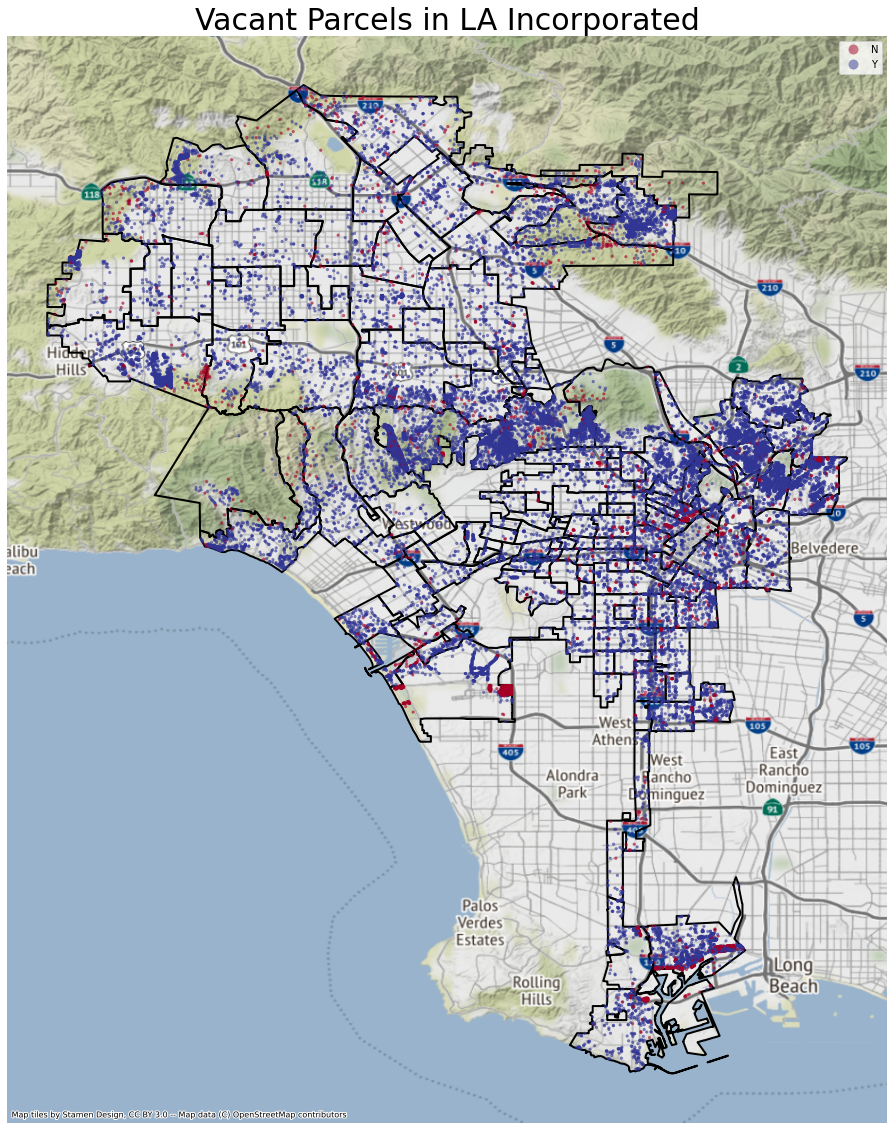

In [13]:
# to map vacant parcels
fig, ax = plt.subplots(figsize=(20,20))

comgdf.plot(ax=ax, edgecolor='k',linewidth=2, color='none')

vacgdf.plot(ax=ax, markersize=5,
                      cmap='RdYlBu',
            alpha=0.5, column='istaxableparcel', legend=True)

# keeping the axis on for now and will turn off later
ax.axis('off')

ax.set_title('Vacant Parcels in LA Incorporated',fontsize=30)

# we are interested in seeing LA county map features and will use this basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs=vacgdf.crs)

plt.savefig('VacantParcels_LA City_All.png', bbox_inches='tight')

In [10]:
vacgdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33091 entries, 0 to 33090
Data columns (total 52 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   usecodedescchar1           33080 non-null  object  
 1   roll_homeownersexemp       33091 non-null  object  
 2   situsunit                  33091 non-null  object  
 3   recordingdate              33091 non-null  object  
 4   effectiveyearbuilt         33091 non-null  object  
 5   istaxableparcel            33091 non-null  object  
 6   roll_totlandimp            33091 non-null  object  
 7   roll_perspropexemp         33091 non-null  object  
 8   parcelboundarydescription  33091 non-null  object  
 9   roll_landbaseyear          33091 non-null  object  
 10  situscity                  33091 non-null  object  
 11  roll_impbaseyear           33091 non-null  object  
 12  usetype                    33080 non-null  object  
 13  cluster                

In [12]:
yuck = vacgdf.loc[vacgdf['ain'] == '5216008016']

In [13]:
treegdf = gpd.read_file("Data/blackwalnut.geojson")

In [14]:
helptreegdf = gpd.read_file("Data/blackwalnut_2080.geojson")

In [15]:
treegdf

cartodb_id   id  gridcode  \
0            87  100         1   
1           464  790         1   
2           202  277         1   
3           203  278         1   
4           204  280         1   
..          ...  ...       ...   
509         513  866         1   
510         514  867         1   
511         497  849         1   
512         498  850         1   
513         499  851         1   

                                              geometry  
0    MULTIPOLYGON (((-120.40990 35.32800, -120.4437...  
1    MULTIPOLYGON (((-116.05168 31.44543, -116.0624...  
2    MULTIPOLYGON (((-119.54383 34.56215, -119.5550...  
3    MULTIPOLYGON (((-119.98183 34.45184, -119.9929...  
4    MULTIPOLYGON (((-118.76262 34.68057, -118.7653...  
..                                                 ...  
509  MULTIPOLYGON (((-115.89801 30.50364, -115.9002...  
510  MULTIPOLYGON (((-115.89801 30.50364, -115.8957...  
511  MULTIPOLYGON (((-115.89269 30.98425, -115.9141...  
512  MULTIPOLYGON (((-116.03608 30.93336, -116.0575...  
513  MULTIPOLYGON (((-115.99086 30.93215, -116.0123...  

[514 rows x 4 columns]

In [16]:
treegdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

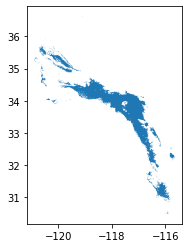

In [17]:
treegdf.plot()

In [18]:
color = helptreegdf.loc[helptreegdf['ncar_2080'] == 'stable', 'color'] = 'yellow'
helptreegdf.loc[helptreegdf['ncar_2080'] == 'loss', 'color'] = 'red'
helptreegdf.loc[helptreegdf['ncar_2080'] == 'gain', 'color'] = 'green'

helptreegdf

cartodb_id ncar_2080                                           geometry  \
0           1    stable  MULTIPOLYGON (((-115.97922 31.01323, -115.9746...   
1           2      loss  MULTIPOLYGON (((-115.89801 30.50364, -115.9002...   
2           3      gain  MULTIPOLYGON (((-116.07807 31.00529, -116.0759...   

    color  
0  yellow  
1     red  
2   green

In [19]:
elsereno = comgdf[comgdf["community"].str.contains("El Sereno") == True]
elsereno

objectid city_type        lcity                    label   source  \
116        78      City  Los Angeles  Los Angeles - El Sereno  LA City   

     shape_starea  shape_stlength  \
116  1.090510e+08    57287.733092   

                                              the_geom  community  
116  MULTIPOLYGON (((-118.15536 34.09867, -118.1553...  El Sereno

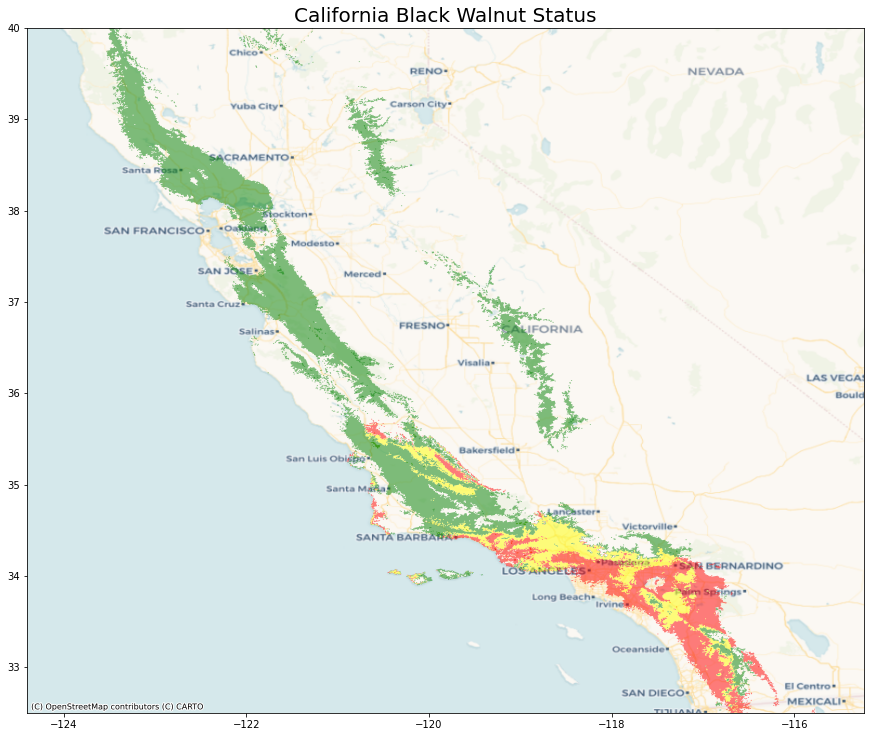

In [20]:
fig, ax = plt.subplots(figsize=(15,15))

helptreegdf.plot(ax=ax, color=helptreegdf.color, legend=True, alpha=.5)

# keeping the axis on for now and will turn off later
ax.axis('on')

ax.set_title('California Black Walnut Status',fontsize=20)

ax.set_ylim([32.5, 40])

# we are interested in seeing LA county map features and will use this basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs=vacgdf.crs)

plt.savefig('California_blackwalnut_range.png', bbox_inches='tight')

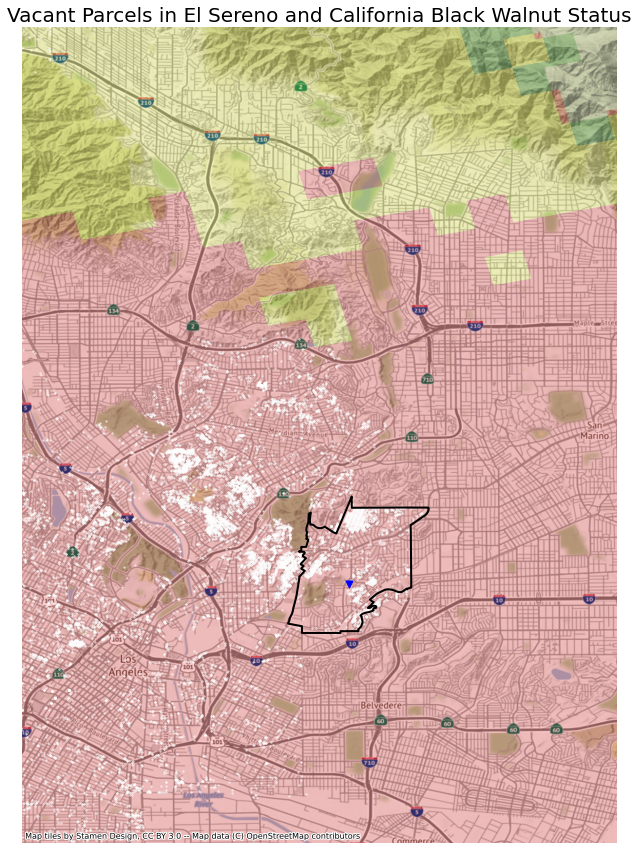

In [26]:
# to map vacant parcels
fig, ax = plt.subplots(figsize=(15,15))

cmap = plt.get_cmap('rainbow')

helptreegdf.plot(ax=ax, 
                 alpha=0.2,
                 legend=True,
                color=helptreegdf.color)

vacgdf.plot(ax=ax, markersize=2,marker='D',
                      color='#FFFFFF',
            alpha=0.4)

elsereno.plot(ax=ax, edgecolor='k',
              linewidth=2,  
              color='none')

yuck.plot(ax=ax, marker = "v", markersize=50, color="blue")

ax.set_xlim([-118.275, -118.1])
ax.set_ylim([34, 34.24])

# keeping the axis on for now and will turn off later
ax.axis('off')

ax.set_title('Vacant Parcels in El Sereno and California Black Walnut Status',fontsize=20)

# we are interested in seeing LA county map features and will use this basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs=vacgdf.crs)

plt.savefig('VacantParcels_Terrain.png', bbox_inches='tight')

In [30]:
url = "https://opendata.arcgis.com/datasets/909fd7034cc24a40aa82b3cf0a62da50_9.geojson"
quake = gpd.read_file(url)

In [31]:
quake.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   OBJECTID       626 non-null    int64   
 1   ID             0 non-null      object  
 2   CA_MAP_LEGEND  626 non-null    object  
 3   QUAD_NAME      626 non-null    object  
 4   RELEASED       626 non-null    object  
 5   REVISED        626 non-null    object  
 6   PREV_DATES     626 non-null    object  
 7   GEOPDFLINK     626 non-null    object  
 8   REPORTLINK     626 non-null    object  
 9   COMMENTS       626 non-null    object  
 10  ShapeSTArea    626 non-null    float64 
 11  ShapeSTLength  626 non-null    float64 
 12  geometry       626 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(9)
memory usage: 63.7+ KB


<AxesSubplot:>

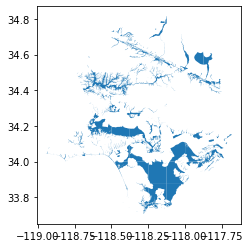

In [32]:
quake.plot()

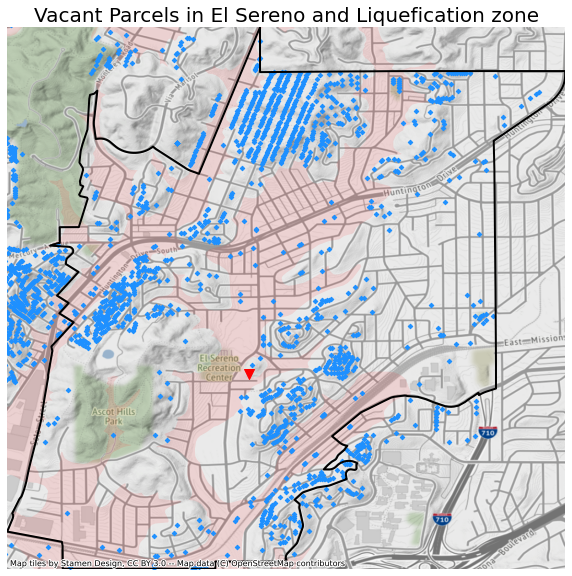

In [44]:
# to map vacant parcels
fig, ax = plt.subplots(figsize=(10,10))

quake.plot(ax=ax, 
                 alpha=0.1,
                 legend=True,
                color="red")

vacgdf.plot(ax=ax, markersize=10,marker='D',
                      color='dodgerblue')

elsereno.plot(ax=ax, edgecolor='k',
              linewidth=2,  
              color='none')

yuck.plot(ax=ax, marker = "v", markersize=100, color="red")

minx, miny, maxx, maxy = elsereno.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# keeping the axis on for now and will turn off later
ax.axis('off')

ax.set_title('Vacant Parcels in El Sereno and Liquefication zone',fontsize=20)

# we are interested in seeing LA county map features and will use this basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs=vacgdf.crs)

plt.savefig('VacantParcels_Terrain.png', bbox_inches='tight')

In [45]:
url2 = "https://opendata.arcgis.com/datasets/4bb7809eac534689b36b2d347ac96220_1.geojson"
fault = gpd.read_file(url2)
fault.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18730 entries, 0 to 18729
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    18730 non-null  int64   
 1   FLT_ZN_NAM  18730 non-null  object  
 2   FLT_AGE     18730 non-null  object  
 3   SLIPRATE    18730 non-null  object  
 4   TOOLTIP     18730 non-null  object  
 5   geometry    18730 non-null  geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 878.1+ KB


<AxesSubplot:>

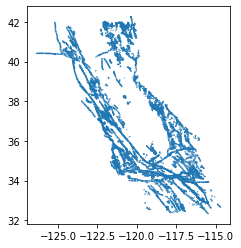

In [46]:
fault.plot()

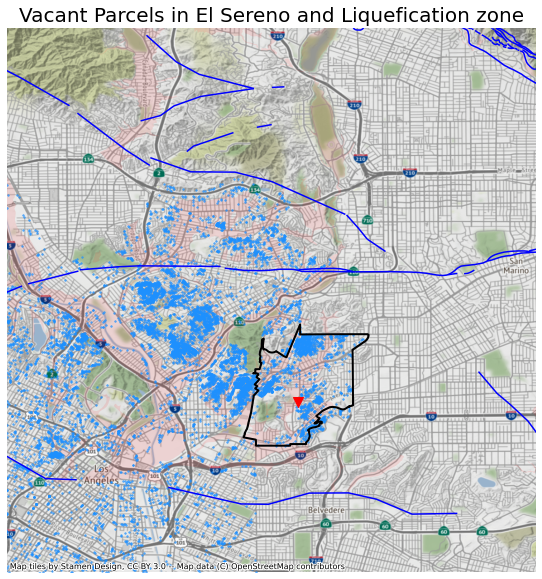

In [51]:
# to map vacant parcels
fig, ax = plt.subplots(figsize=(10,10))

quake.plot(ax=ax, 
                 alpha=0.1,
                 legend=True,
                color="red")

vacgdf.plot(ax=ax, markersize=2,marker='D', alpha=0.5,
                      color='dodgerblue')

elsereno.plot(ax=ax, edgecolor='k',
              linewidth=2,  
              color='none')

yuck.plot(ax=ax, marker = "v", markersize=100, color="red")
fault.plot(ax=ax, color="blue")

ax.set_xlim([-118.275, -118.1])
ax.set_ylim([34.02, 34.2])

# keeping the axis on for now and will turn off later
ax.axis('off')

ax.set_title('Vacant Parcels in El Sereno and Liquefication zone',fontsize=20)

# we are interested in seeing LA county map features and will use this basemap
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs=vacgdf.crs)

plt.savefig('VacantParcels_Terrain.png', bbox_inches='tight')

In [ ]:
elsereno.bounds

In [ ]:
gdf.loc[gdf['NEIGHBORHO'] == 'Chinatown', 'color'] = '#c80550'
gdf.loc[gdf['NEIGHBORHO'] == 'Downtown/Civic Center', 'color'] = '#677617'
gdf.loc[gdf['NEIGHBORHO'] == 'Western Addition', 'color'] = '#569abd'

gdf_web_mercator.plot(ax=ax, 

                      alpha=0.7,
                      color = gdf_web_mercator.color